# Training a classifier

## What about data?

- For images, packages such as Pillow, OpenCV are useful.
    - 画像ならPillowかOpenCV
- For audio, packages such as scipy and librosa
    - 音声ならscipyとlibrosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful.
    - テキストなら生パイソンかcythonで読み込むか、NLTKとsSpaCyが便利

## Training an image classifier

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
transform

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

画像を見てみる

plane plane   car  deer


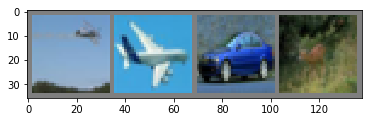

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolution Neural Network

In [7]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
net = Net()

net

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

### 3. Define a Loss function and optimizer

クロスエントロピーを損失関数に

SGDをOptimizerに設定

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [14]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.218
[1,  4000] loss: 1.874
[1,  6000] loss: 1.661
[1,  8000] loss: 1.560
[1, 10000] loss: 1.500
[1, 12000] loss: 1.456
[2,  2000] loss: 1.408
[2,  4000] loss: 1.355
[2,  6000] loss: 1.337
[2,  8000] loss: 1.325
[2, 10000] loss: 1.295
[2, 12000] loss: 1.299
Finished Training


### 5. Test the network on the test data

NNが学習したものを見てみる

GroundTruth:    cat  ship  ship plane


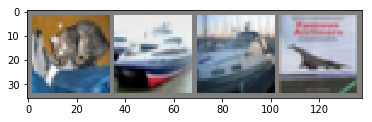

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

どのクラスに分類されているか見てみる

In [17]:
outputs = net(Variable(images))

In [18]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j][0]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 76 %
Accuracy of  bird : 53 %
Accuracy of   cat : 19 %
Accuracy of  deer : 25 %
Accuracy of   dog : 46 %
Accuracy of  frog : 76 %
Accuracy of horse : 55 %
Accuracy of  ship : 68 %
Accuracy of truck : 68 %


## Training on GPU

In [20]:
net.cuda()

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

In [25]:
inputs = Variable(inputs.cuda())
labels = Variable(labels.cuda())

RuntimeError: Variable data has to be a tensor, but got Variable

In [24]:
inputs.cuda()

Variable containing:
(0 ,0 ,.,.) = 
 -0.4431 -0.6000 -0.8275  ...   0.9294  0.9294  0.9294
 -0.5686 -0.7882 -0.8431  ...   0.9608  0.9608  0.9608
 -0.6392 -0.8275 -0.8353  ...   0.9451  0.9451  0.9529
           ...             ⋱             ...          
 -0.3412 -0.3725 -0.4431  ...  -0.7961 -0.7647 -0.7569
 -0.1922 -0.2706 -0.2863  ...  -0.7961 -0.7569 -0.7098
 -0.2549 -0.2941 -0.2627  ...  -0.8431 -0.8588 -0.8196

(0 ,1 ,.,.) = 
 -0.4431 -0.6000 -0.8275  ...   0.9294  0.9294  0.9294
 -0.5686 -0.7882 -0.8431  ...   0.9608  0.9608  0.9608
 -0.6392 -0.8275 -0.8353  ...   0.9451  0.9451  0.9529
           ...             ⋱             ...          
 -0.4275 -0.4588 -0.5294  ...  -0.7961 -0.7647 -0.7569
 -0.2784 -0.3569 -0.3725  ...  -0.7961 -0.7569 -0.7098
 -0.3412 -0.3804 -0.3412  ...  -0.8431 -0.8588 -0.8196

(0 ,2 ,.,.) = 
 -0.4431 -0.6000 -0.8275  ...   0.9294  0.9294  0.9294
 -0.5686 -0.7882 -0.8431  ...   0.9608  0.9608  0.9608
 -0.6392 -0.8275 -0.8353  ...   0.9451  0.9451  0.95

In [29]:
inputs = inputs.cuda()
labels = labels.cuda()

In [30]:
outputs = net(inputs)

In [31]:
outputs

Variable containing:
-0.0700  2.5308 -2.2110 -0.0538 -2.5689 -0.6222 -1.1495 -0.3539  2.2907  2.5845
 4.3148 -1.7716  1.9649 -1.1523  1.3715 -1.3376 -2.6143 -3.0948  4.0024 -1.6358
-0.7171  3.2906 -2.2250 -0.0333 -1.4046 -0.9158  1.2587 -1.3805 -1.3799  4.5937
-0.4694 -4.9059  2.9438  1.7659  2.1228  2.8001 -1.1809  0.6998 -1.4667 -2.8538
[torch.cuda.FloatTensor of size 4x10 (GPU 0)]